# Singular Value Decomposition Analysis

## Imports 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from kneed import KneeLocator

from fault_tolerant_ml.data.mnist import MNist
from fault_tolerant_ml.data import cifar10

%reload_ext autoreload
%autoreload 2

## Helpers

In [2]:
def analyse_svd(X, y, n_workers, overlaps):
    u, s, v = np.linalg.svd(X, full_matrices=False)
    idx = np.argwhere(np.cumsum(s) / np.sum(s) > 0.95).flatten()[0]
    print(f"Idx for entire dataset 95% variance: {idx}")
    all_idxs = {}
    for n in n_workers:
        print(f"SVD for {n} workers")
        overlap_dict = {}
        for overlap in overlaps:
            batch_size = int(np.ceil(mnist.n_samples / n))
            batch_gen = MNist.next_batch(
                X,
                y,
                batch_size,
                shuffle=False,
                overlap=overlap
            )
            avg_idxs = []
            for i, (X_batch, y_batch) in enumerate(batch_gen):
                u_batch, s_batch, v_batch = np.linalg.svd(X_batch.data, full_matrices=False)
                idx = np.argwhere(np.cumsum(s_batch) / np.sum(s_batch) > 0.95).flatten()[0]
                avg_idxs.append(idx)

            overlap_dict[overlap] = np.mean(avg_idxs)
            all_idxs[n] = overlap_dict
            print(f"batch_size={X_batch.shape[0]}")
                # print(f"Worker {i}: 95% variance={idx}")
            print(f"Overlap={overlap}, Avg idxs hover around: {np.mean(avg_idxs)}, with std of: {np.std(avg_idxs)}")
            
    return all_idxs

In [3]:
def svd_to_data_size(partition_sizes, X):
    idxs_across_data_size = []
    for p in partition_sizes:
        random_idxs = np.random.choice(np.arange(X.shape[0]), size=(p,))
        X_b = X[random_idxs]
        u_b, s_b, v_b = np.linalg.svd(X_b, full_matrices=False)
        idx = np.argwhere(np.cumsum(s_b) / np.sum(s_b) > 0.95).flatten()[0]
        idxs_across_data_size.append(idx)
        print(f"X_b.shape={X_b.shape}, Idx: {idx}")
        
    return idxs_across_data_size

## Load in data

### Mnist 

In [5]:
data_dir = "../data/mnist/"
filepaths = {
    "train": {
        "images": os.path.join(data_dir, "train-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "train-labels-idx1-ubyte.gz")
    },
    "test": {
        "images": os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz")
    }
}
mnist = MNist(filepaths)

### Fashion mnist

In [5]:
data_dir = "../data/fashion-mnist/"
filepaths = {
    "train": {
        "images": os.path.join(data_dir, "train-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "train-labels-idx1-ubyte.gz")
    },
    "test": {
        "images": os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz")
    }
}
fashion_mnist = MNist(filepaths)

### Cifar

In [6]:
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar10.load_data()
x_train_c = x_train_c.reshape(-1, 3072)
x_test_c = x_test_c.reshape(-1, 3072)

File already exists at /Users/sashlinreddy/.ftml/datasets/cifar-10-batches-py.tar.gz. No need to download


## Overlap SVD Analysis

In [12]:
u, s, v = np.linalg.svd(mnist.X_train[0:100].data)
u2, s2, v2 = np.linalg.svd(mnist.X_train[100:200].data)

In [13]:
s.sum()

589.2215

In [14]:
s2.sum()

600.6774

In [122]:
n_workers = [2, 8, 16, 32, 64, 128]
overlaps = [0.0, 0.2, 0.4, 0.6, 0.8]

In [123]:
all_idxs = analyse_svd(mnist.X_train.data, mnist.y_train.data, n_workers, overlaps)

Idx for entire dataset 95% variance: 426
SVD for 2 workers
batch_size=30000
Overlap=0.0, Avg idxs hover around: 424.5, with std of: 0.5
batch_size=36000
Overlap=0.2, Avg idxs hover around: 425.0, with std of: 0.0
batch_size=42000
Overlap=0.4, Avg idxs hover around: 425.0, with std of: 0.0
batch_size=48000
Overlap=0.6, Avg idxs hover around: 426.0, with std of: 0.0
batch_size=54000
Overlap=0.8, Avg idxs hover around: 426.0, with std of: 0.0
SVD for 8 workers
batch_size=7500
Overlap=0.0, Avg idxs hover around: 417.0, with std of: 1.224744871391589
batch_size=9000
Overlap=0.2, Avg idxs hover around: 419.0, with std of: 1.224744871391589
batch_size=10500
Overlap=0.4, Avg idxs hover around: 419.875, with std of: 1.2686114456365274
batch_size=12000
Overlap=0.6, Avg idxs hover around: 421.0, with std of: 1.4142135623730951
batch_size=13500
Overlap=0.8, Avg idxs hover around: 421.25, with std of: 1.0897247358851685
SVD for 16 workers
batch_size=3750
Overlap=0.0, Avg idxs hover around: 408.1875

KeyboardInterrupt: 

In [93]:
all_idxs

{2: {0.0: 424.5, 0.2: 425.0, 0.4: 425.0, 0.6: 426.0, 0.8: 426.0},
 8: {0.0: 417.0, 0.2: 419.0, 0.4: 419.875, 0.6: 421.0, 0.8: 421.25},
 16: {0.0: 408.1875, 0.2: 411.625, 0.4: 413.8125, 0.6: 415.0625, 0.8: 416.125},
 32: {0.0: 392.4375,
  0.2: 397.78125,
  0.4: 401.34375,
  0.6: 404.21875,
  0.8: 406.4375},
 64: {0.0: 361.109375,
  0.2: 371.9375,
  0.4: 379.5,
  0.6: 384.984375,
  0.8: 389.203125},
 128: {0.0: 290.109375,
  0.2: 315.9296875,
  0.4: 332.765625,
  0.6: 345.1171875,
  0.8: 354.2109375}}

[0.01415    0.0556     0.10885    0.2093     0.39857547 0.66386585]


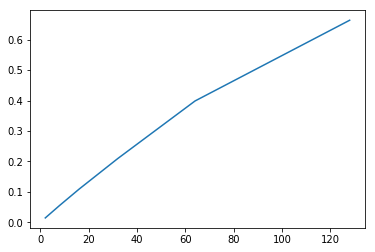

In [128]:
svd_idxs = np.array([424.5, 417.0, 408.1875, 392.4375, 361.109375, 290.109375])
batch_sizes = np.array([30000, 7500, 3750, 1875, 906, 437])
normalized_idx = svd_idxs / batch_sizes
print(normalized_idx)
plt.scatter(svd_idxs, )

In [129]:
mnist_overlap = pd.read_csv("../data/output/mnist-results-overlap.csv")

In [137]:
mnist_overlap.loc[:, "BATCH_SIZE"] = (
    np.ceil(
        (1 + mnist_overlap.loc[:, "OVERLAP"]) * (60000 // (mnist_overlap.loc[:, "N_WORKERS"] - 1))
    ).astype(int)
)

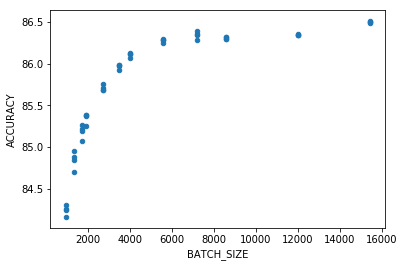

In [140]:
mnist_overlap.loc[mnist_overlap.loc[:, "COMM_PERIOD"].isin([1, 10, 20, 100]), ["BATCH_SIZE", "ACCURACY"]].plot(kind="scatter", x="BATCH_SIZE", y="ACCURACY")

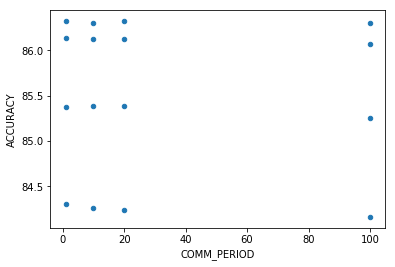

In [151]:
# _, axes = plt.subplots(2, 2, figsize=(16, 4))
# plt.subplots_adjust(hspace=0.8)
# workers = [8, 16, 32, 64]
# for i, w in enumerate(workers):
#     row = i // 2
#     col = i % 2
#     # axes[row][col].scatter()
#     condition = (mnist_overlap.loc[:, "N_WORKERS"] == w) & (mnist_overlap.loc[:, "OVERLAP"] == 0.0) & (mnist_overlap.loc[:, "COMM_PERIOD"].isin([1, 10, 20, 100]))
#     mnist_overlap.loc[condition, ["COMM_PERIOD", "ACCURACY"]].plot(kind="scatter", y="ACCURACY", x="COMM_PERIOD", ax=axes[row][col])
#     axes[row][col].set_title(f"Worker {w}")
condition = (mnist_overlap.loc[:, "OVERLAP"] == 0.0) & (mnist_overlap.loc[:, "COMM_PERIOD"].isin([1, 10, 20, 100]))
mnist_overlap.loc[condition, ["COMM_PERIOD", "ACCURACY"]].plot(kind="scatter", y="ACCURACY", x="COMM_PERIOD")

In [83]:
mnist_overlap.pivot_table(
    values=["BATCH_SIZE", "TIME", "ACCURACY"],
    index=["N_WORKERS", "COMM_PERIOD"],
    columns=["OVERLAP"]
)

ACCURACY               BATCH_SIZE                \
OVERLAP                    0.0    0.4    0.8        0.0    0.4    0.8   
N_WORKERS COMM_PERIOD                                                   
8         1              86.32  86.35  86.50       8571  12000  15428   
          10             86.30  86.35  86.50       8571  12000  15428   
          20             86.32  86.35  86.51       8571  12000  15428   
          40             86.27  86.41  86.50       8571  12000  15428   
          80             86.29  86.34  86.44       8571  12000  15428   
          100            86.30  86.36  86.49       8571  12000  15428   
16        1              86.13  86.29  86.29       4000   5600   7200   
          10             86.12  86.29  86.36       4000   5600   7200   
          20             86.12  86.25  86.39       4000   5600   7200   
          40             86.19  86.23  86.38       4000   5600   7200   
          80             86.22  86.32  86.38       4000   5600   7200   
          100            86.07  86.30  86.35       4000   5600   7200   
32        1              85.37  85.76  85.99       1935   2709   3483   
          10             85.38  85.71  85.97       1935   2709   3483   
          20             85.39  85.68  85.98       1935   2709   3483   
          40             85.57  85.80  86.08       1935   2709   3483   
          80             85.80  86.00  86.20       1935   2709   3483   
          100            85.25  85.68  85.93       1935   2709   3483   
64        1              84.30  84.95  85.26        952   1333   1714   
          10             84.26  84.88  85.22        952   1333   1714   
          20             84.24  84.85  85.19        952   1333   1714   
          40             84.55  85.10  85.46        952   1333   1714   
          80             84.85  85.38  85.73        952   1333   1714   
          100            84.16  84.70  85.07        952   1333   1714   

                            TIME                        
OVERLAP                      0.0        0.4        0.8  
N_WORKERS COMM_PERIOD                                   
8         1            17.210551  21.487015  25.625124  
          10           11.780788  16.035784  20.158040  
          20           11.454207  15.649399  19.840704  
          40           13.419973  18.384064  23.190774  
          80           17.362270  23.922885  30.644104  
          100          11.262548  15.524620  19.734402  
16        1            15.975141  16.849420  18.140218  
          10            7.403856   9.759100  11.984868  
          20            7.077538   9.375863  11.771325  
          40            7.804751  10.364799  12.985963  
          80            9.540637  13.141877  16.372380  
          100           6.697726   9.145191  11.496845  
32        1            19.247735  20.878171  23.610446  
          10            6.097701   7.777934   9.221584  
          20            5.433597   6.786178   8.395383  
          40            5.442882   7.136898   8.725446  
          80            6.243352   8.255326  10.351678  
          100           4.774168   6.220434   7.641300  
64        1            22.322847  29.500941  33.525853  
          10            5.809648   6.288394   7.602529  
          20            4.375286   5.396891   6.504640  
          40            4.282843   5.366429   6.475087  
          80            4.538051   5.760224   7.187536  
          100           3.702456   4.590924   5.711209

In [157]:
all_idxs_f = analyse_svd(fashion_mnist.X_train.data, mnist.y_train.data, n_workers, overlaps)

Idx for entire dataset 95% variance: 598
SVD for 2 workers
batch_size=30000
Overlap=0.0, Avg idxs hover around: 596.5, with std of: 0.5
batch_size=36000
Overlap=0.2, Avg idxs hover around: 597.5, with std of: 0.5
batch_size=42000
Overlap=0.4, Avg idxs hover around: 597.5, with std of: 0.5
batch_size=48000
Overlap=0.6, Avg idxs hover around: 598.0, with std of: 0.0
batch_size=54000
Overlap=0.8, Avg idxs hover around: 598.0, with std of: 0.0
SVD for 8 workers
batch_size=7500
Overlap=0.0, Avg idxs hover around: 587.625, with std of: 0.8569568250501305
batch_size=9000
Overlap=0.2, Avg idxs hover around: 589.5, with std of: 0.7071067811865476
batch_size=10500
Overlap=0.4, Avg idxs hover around: 591.0, with std of: 1.0
batch_size=12000
Overlap=0.6, Avg idxs hover around: 592.25, with std of: 0.6614378277661477
batch_size=13500
Overlap=0.8, Avg idxs hover around: 593.0, with std of: 0.7071067811865476
SVD for 16 workers
batch_size=3750
Overlap=0.0, Avg idxs hover around: 575.3125, with std of

,2,8,16,32,64,128
0.0,424.5,417.000,408.1875,392.43750,361.109375,290.109375
0.2,425.0,419.000,411.6250,397.78125,371.937500,315.929688
0.4,425.0,419.875,413.8125,401.34375,379.500000,332.765625
0.6,426.0,421.000,415.0625,404.21875,384.984375,345.117188
0.8,426.0,421.250,416.1250,406.43750,389.203125,354.210938


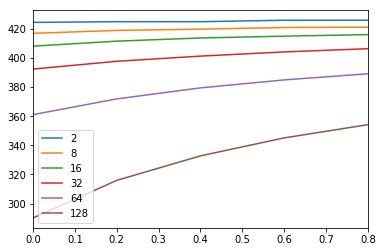

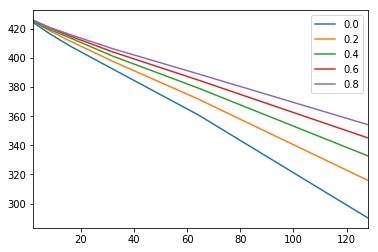

In [97]:
df = pd.DataFrame(all_idxs)
display(df.head())
display(df.plot())
display(df.T.plot())

,2,8,16,32,64,128
0.0,596.5,587.625,575.3125,548.43750,484.500000,328.773438
0.2,597.5,589.500,579.6250,557.65625,507.593750,375.445312
0.4,597.5,591.000,582.5000,564.18750,522.828125,414.976562
0.6,598.0,592.250,584.5000,568.87500,533.890625,445.953125
0.8,598.0,593.000,586.2500,572.28125,542.171875,468.109375


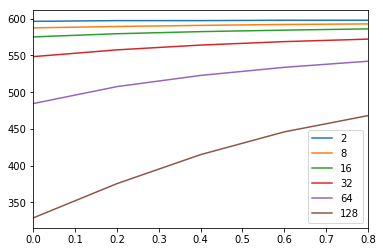

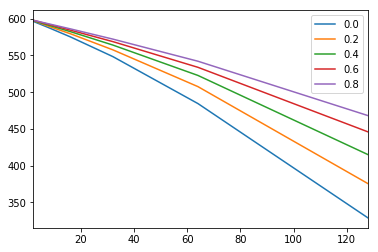

In [158]:
df_f = pd.DataFrame(all_idxs_f)
display(df_f.head())
display(df_f.plot())
display(df_f.T.plot())

## SVD Analysis of data sizes

In [46]:
%%time
partition_sizes = [1000, 2000, 4000, 8000, 16000, 30000, 60000]
idxs_across_data_size = svd_to_data_size(partition_sizes, mnist.X_train.data)
print(idxs_across_data_size)

X_b.shape=(1000, 784), Idx: 371
X_b.shape=(2000, 784), Idx: 396
X_b.shape=(4000, 784), Idx: 411
X_b.shape=(8000, 784), Idx: 417
X_b.shape=(16000, 784), Idx: 422
X_b.shape=(30000, 784), Idx: 424
X_b.shape=(60000, 784), Idx: 425
[371, 396, 411, 417, 422, 424, 425]
CPU times: user 58.4 s, sys: 5.29 s, total: 1min 3s
Wall time: 13.5 s


In [47]:
%%time
idxs_across_data_size_f = svd_to_data_size(partition_sizes, fashion_mnist.X_train.data)
print(idxs_across_data_size_f)

X_b.shape=(1000, 784), Idx: 490
X_b.shape=(2000, 784), Idx: 553
X_b.shape=(4000, 784), Idx: 576
X_b.shape=(8000, 784), Idx: 586
X_b.shape=(16000, 784), Idx: 593
X_b.shape=(30000, 784), Idx: 596
X_b.shape=(60000, 784), Idx: 596
[490, 553, 576, 586, 593, 596, 596]
CPU times: user 1min 1s, sys: 5.87 s, total: 1min 7s
Wall time: 14.4 s


In [48]:
%%time
partition_sizes_c = [1000, 2000, 4000, 8000, 16000, 25000, 50000]
idxs_across_data_size_c = svd_to_data_size(partition_sizes_c, x_train_c)
print(idxs_across_data_size_c)

X_b.shape=(1000, 3072), Idx: 653
X_b.shape=(2000, 3072), Idx: 1025
X_b.shape=(4000, 3072), Idx: 1285
X_b.shape=(8000, 3072), Idx: 1404
X_b.shape=(16000, 3072), Idx: 1459
X_b.shape=(25000, 3072), Idx: 1487
X_b.shape=(50000, 3072), Idx: 1504
[653, 1025, 1285, 1404, 1459, 1487, 1504]
CPU times: user 15min 28s, sys: 29.7 s, total: 15min 58s
Wall time: 2min 55s


In [49]:
kn = KneeLocator(partition_sizes, idxs_across_data_size, curve='concave', direction='increasing')
kn_f = KneeLocator(partition_sizes, idxs_across_data_size_f, curve='concave', direction='increasing')
kn_c = KneeLocator(partition_sizes_c, idxs_across_data_size_c, curve='concave', direction='increasing')
print(kn.knee)
print(kn_f.knee)
print(kn_c.knee)

8000
8000
8000


In [61]:
partition_sizes_c

[1000, 2000, 4000, 8000, 16000, 25000, 50000]

In [120]:
workers = np.ceil(60000 / np.array(partition_sizes))
workers_f = np.ceil(60000 / np.array(partition_sizes))
workers_c = np.ceil(50000 / np.array(partition_sizes_c))
print(f"workers={list(zip(partition_sizes, workers))}")
print(f"workers_f={list(zip(partition_sizes, workers_f))}")
print(f"workers_c={list(zip(partition_sizes, workers_c))}")
knee = workers_c[np.argwhere(partition_sizes == kn.knee).flatten()][0]
knee_f = workers_c[np.argwhere(partition_sizes == kn_f.knee).flatten()][0]
knee_c = workers_c[np.argwhere(partition_sizes_c == kn_c.knee).flatten()][0]
print(f"knee={knee}")
print(f"knee_f={knee_f}")
print(f"knee_c={knee_c}")

workers=[(1000, 60.0), (2000, 30.0), (4000, 15.0), (8000, 8.0), (16000, 4.0), (30000, 2.0), (60000, 1.0)]
workers_f=[(1000, 60.0), (2000, 30.0), (4000, 15.0), (8000, 8.0), (16000, 4.0), (30000, 2.0), (60000, 1.0)]
workers_c=[(1000, 50.0), (2000, 25.0), (4000, 13.0), (8000, 7.0), (16000, 4.0), (30000, 2.0), (60000, 1.0)]
knee=7.0
knee_f=7.0
knee_c=7.0


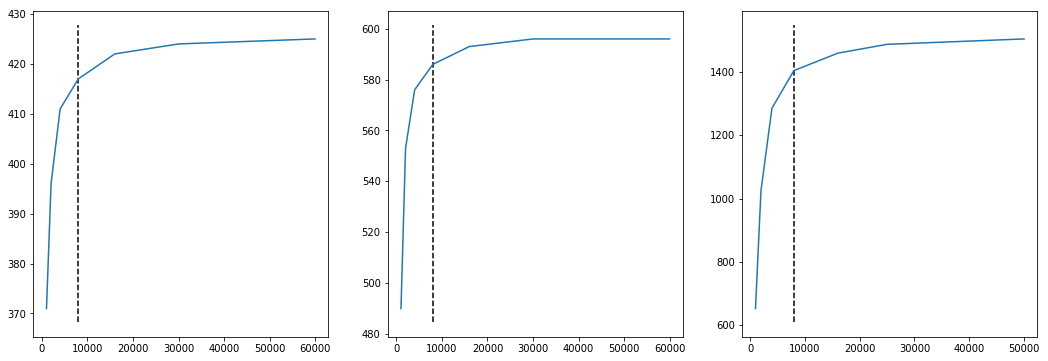

In [112]:
_, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].plot(partition_sizes, idxs_across_data_size)
axes[1].plot(partition_sizes, idxs_across_data_size_f)
axes[2].plot(partition_sizes_c, idxs_across_data_size_c)
# axes[2].set_xlim(workers_c[0], workers_c[-1])
axes[0].vlines(kn.knee, axes[0].get_ylim()[0], axes[0].get_ylim()[1], linestyles='dashed')
axes[1].vlines(kn_f.knee, axes[1].get_ylim()[0], axes[1].get_ylim()[1], linestyles='dashed')
axes[2].vlines(kn_c.knee, axes[2].get_ylim()[0], axes[2].get_ylim()[1], linestyles='dashed')

In [12]:
interpolation = np.interp(np.arange(partition_sizes[-1]), partition_sizes, idxs_across_data_size)
interpolation

array([363.        , 363.        , 363.        , ..., 424.9998    ,
       424.99986667, 424.99993333])

In [15]:
interpolation[3999]

410.9915

In [22]:
int(np.ceil(mnist.n_samples / (kn.knee / 2)))

15

Okay so the diversity of the data is different for the different number of workers. With the increase of the number of workers, 

In [10]:
X_train = mnist.X_train.data.copy()
y_train = mnist.y_train.data.copy()

In [9]:
u, s, v = np.linalg.svd(mnist.X_train.data, full_matrices=False)
idx = np.argwhere(np.cumsum(s) / np.sum(s) > 0.95).flatten()[0]
print(f"Idx for entire dataset 95% variance: {idx}")
n_iterations = 10
n = n_workers[2] # 8
overlap = 0.0
for i in np.arange(n_iterations):
    # Shuffle data
    shuffle_idxs = np.random.permutation(np.arange(X_train.shape[0]))
    X_train = X_train[shuffle_idxs]
    y_train = y_train[shuffle_idxs]
    batch_size = int(np.ceil(mnist.n_samples / n))
    batch_gen = MNist.next_batch(
        X_train,
        y_train,
        batch_size,
        shuffle=False,
        overlap=overlap
    )
    avg_idxs = []
    for i, (X_batch, y_batch) in enumerate(batch_gen):
        u_batch, s_batch, v_batch = np.linalg.svd(X_batch.data, full_matrices=False)
        idx = np.argwhere(np.cumsum(s_batch) / np.sum(s_batch) > 0.95).flatten()[0]
        avg_idxs.append(idx)

    all_idxs[n] = avg_idxs
    print(f"batch_size={X_batch.shape[0]}")
        # print(f"Worker {i}: 95% variance={idx}")
    print(f"Overlap={overlap}, Avg idxs hover around: {np.mean(avg_idxs)}, with std of: {np.std(avg_idxs)}")

Idx for entire dataset 95% variance: 426
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.1875, with std of: 2.310810193417019
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.15625, with std of: 2.195298598710435
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.25, with std of: 1.8874586088176875
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.3125, with std of: 2.0223362109204297
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.15625, with std of: 1.5229366163764007
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.09375, with std of: 2.566117872877238
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.1875, with std of: 2.603333199957316
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.0, with std of: 2.9368350311176825
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.09375, with std of: 2.4667713589832356
batch_size=1875
Overlap=0.0, Avg idxs hover around: 394.09375, with std of: 2.5782670415416633


In [15]:
labels = np.argmax(y_train, axis=1)

In [ ]:
labels

In [ ]:
(labels == 9) | (labels == 0)

In [28]:
X_9 = X_train[np.argwhere((labels == 9) | (labels == 0)).flatten()]
u9, s9, v9 = np.linalg.svd(X_9, full_matrices=False)
np.argwhere(np.cumsum(s9) / np.sum(s9) > 0.95).flatten()[0]

373

In [29]:
def strat_sample(total_samples, sample_size):
    total_samples = total_samples + (total_samples % sample_size)
    assert (total_samples % sample_size == 0)
    d_s = 1.0 / sample_size
    bins = np.zeros(total_samples, dtype=int)
    count = 0
    for i in range(total_samples // sample_size):
        bins[count:count + sample_size] = np.random.permutation(sample_size)
        count += sample_size
    place_in_bin = np.random.uniform(-0.5 * d_s, 0.5 * d_s, total_samples) + (bins + 0.5) * d_s
    return place_in_bin

In [33]:
strat_sample(60000, 10)

array([0.34725767, 0.84779425, 0.7489765 , ..., 0.32738261, 0.83816821,
       0.67517554])

In [35]:
from collections import Counter

In [36]:
Counter(labels)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [71]:
bins = np.bincount(labels)
strata_size = 4000 / 60000 * bins

In [72]:
np.floor(strata_size).astype(int)

array([394, 449, 397, 408, 389, 361, 394, 417, 390, 396])

In [73]:
bins

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [74]:
sample = []
for label in np.unique(labels):
    X_label = X_train[labels == label]
    label_partition = np.random.choice(np.arange(bins[label]), size=(np.floor(strata_size[label]).astype(int)))
    X_sample = X_label[label_partition]
    print(f"X_sample={X_sample.shape}")
    sample.append(X_sample)

X_sample=(394, 784)
X_sample=(449, 784)
X_sample=(397, 784)
X_sample=(408, 784)
X_sample=(389, 784)
X_sample=(361, 784)
X_sample=(394, 784)
X_sample=(417, 784)
X_sample=(390, 784)
X_sample=(396, 784)


In [76]:
strat_samp = np.vstack(sample)
i = np.arange(strat_samp.shape[0])

In [77]:
np.random.shuffle(i)

In [78]:
i

array([1965, 3874,  900, ..., 2640, 1917, 2874])

In [79]:
u_, s_, v_ = np.linalg.svd(strat_samp[i], full_matrices=False)
np.argwhere(np.cumsum(s_) / np.sum(s_) > 0.95).flatten()[0]

411

In [4]:
svds = np.array([423.0, 422.0, 424.0])

In [5]:
max_svd = np.max(svds)

In [22]:
normalized = (svds / max_svd)
max_iter = 100
comms = np.floor(normalized * max_iter / 1).astype(int)

In [20]:
normalized

array([0.99764151, 0.99528302, 1.        ])

In [19]:
normalized * max_iter

array([ 99.76415094,  99.52830189, 100.        ])

In [23]:
comms

array([ 99,  99, 100])

In [24]:
svds.sum()

1269.0

In [25]:
np.exp(svds) / np.exp(svds.sum())

/Users/sashlinreddy/miniconda3/envs/ftml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([0., 0., 0.])